# Prediction of relevant protein kinase-cancer relations
We aim to learn pairs (x,y), where x is a protein kinase and y is a cancer that 
can be effectively treated by inhibiting x. We use word2vec to embed words found
in abstracts from the PubMed corpus; we use [marea](https://github.com/TheJacksonLaboratory/marea) to preprocess PubMed abstracts by replacing words and phrases with concept IDs, followed by analysis with [embiggen](https://pypi.org/project/embiggen/) for word embedding. This notebook imports the embedded vectors and corresponding labels (words) from embiggen. We then extract vectors that correspond to
both protein kinases and cancers. We use a positive set of (x,y) relations that
we have derived from an analysis of Clinical Trials data with [yatcp](https://github.com/monarch-initiative/yactp), and rank other possible protein-kinase cancer relations.

## How to set up this notebook
This notebook depends on the files ``embedding_SG_dim100_upto2020.npy``, ``words_SG_upto2020.txt`` (from embiggen), 
``KCET_positive_2021.tsv``, and ``KCET_prediction_2021.tsv`` from the [KCET](https://github.com/TheJacksonLaboratory/KCET) package. For now, the corresponding files are available in
Google drive. Download that folder to someplace on your drive, and then cd to the KCET/notebooks folder,
and softlist the downloaded folder
```
ln -s /path/to/downloaded/folder/ data
```
This notebook assumes it will find the files there.

In [15]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sys.path.insert(0, os.path.abspath('../..'))
from kcet import KinasePredictor

## Input files
``embedding_Skipgram_dim100.npy`` is the result of word2vec embedding of pubmed. ``words.txt`` are the corresponding words. A directory of files was downloaded and softlinked to data using ``ln -s <path> data``.

In [16]:
data_directory = '../data/embeddings_final'
if not os.path.isdir(data_directory):
    raise FileNotFoundError("Could not find data directory")
#embedding_file = os.path.join(data_directory, "embedding_skipgram_dim100.npy")
embedding_file = os.path.join(data_directory, "embedding_SG_dim100_upto2020.npy")
words_file = os.path.join(data_directory, "words_SG_upto2020.txt")
predictor = KinasePredictor(embeddings=embedding_file, words=words_file)


[INFO] We ingested 293274 labeled word vectors from ../data/embeddings_final/embedding_SG_dim100_upto2020.npy and ../data/embeddings_final/words_SG_upto2020.txt
[INFO] We ingested 522 symbol/NCBI gene id mappings from /Users/ravanv/PycharmProjects/KCET/input/prot_kinase.tsv
[INFO] We ingested 698 meshId/disease mappings from /Users/ravanv/PycharmProjects/KCET/input/neoplasms_labels.tsv



# PubMed Word Embeddings
The following code displays the numbers of word embeddings used as input.

In [17]:
embeddings = predictor.get_embeddings()
embeddings.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,2.892186,-4.601290,1.886768,3.363972,5.323241,2.037415,-4.547163,2.887746,0.078090,-6.857232,...,-2.348537,4.792399,3.246019,-3.045483,-4.771703,6.965374,-1.852824,0.788342,0.692204,8.816134
patient,3.030980,-4.654769,1.988458,3.286587,4.494266,4.335152,-3.879949,1.414752,0.948940,-4.057512,...,-1.655231,5.274243,5.277645,-1.659015,-4.128818,5.872729,-3.746760,1.387476,-0.132648,8.704845
meshd009369,3.125736,-5.037050,1.834232,3.044192,4.652200,3.345147,-2.471191,2.407151,0.459735,-5.215952,...,-1.343417,3.949077,5.909581,-3.753628,-5.255637,6.504014,-3.489765,1.265763,0.166798,9.207653
0,3.207781,-5.854365,2.169951,2.806666,3.704714,4.489932,-3.641227,2.849144,1.368201,-5.305769,...,-1.802601,4.349891,5.042999,-1.330444,-3.057492,6.769782,-4.191097,0.704711,0.271818,7.927824
study,3.093263,-3.081187,1.896351,3.586287,3.835986,3.025896,-3.602392,3.394049,0.388296,-4.770427,...,-1.487065,4.371748,4.851753,-3.033936,-4.145646,6.956510,-3.810457,0.859616,0.380740,8.665388
1,3.018538,-3.605780,2.182852,2.932359,3.923348,3.637897,-3.416155,2.005841,1.166031,-4.748892,...,-1.323698,4.395097,3.887243,-2.264642,-3.399752,6.595658,-3.176540,0.921026,-0.217930,8.002831
use,3.175536,-3.883943,2.084331,2.947140,4.180398,4.311874,-4.265388,2.095730,0.419745,-5.925326,...,-2.399938,4.892245,3.914755,-2.971247,-3.429977,5.416573,-4.076387,1.561274,0.717877,9.099863
treatment,3.261678,-3.350174,2.096332,3.783587,2.961497,3.400727,-3.728835,2.151285,0.226021,-4.506880,...,-1.157140,5.029034,5.780355,-3.293498,-3.552152,6.936460,-2.832863,0.838427,0.488065,8.168900
expression,3.106493,-3.050670,2.355245,3.814924,3.019568,3.326808,-3.774094,1.754938,0.224645,-5.438403,...,-2.060218,3.289309,3.884068,-1.966218,-5.751972,6.421821,-3.770080,1.560570,0.603475,9.072812
2,3.148104,-3.438452,2.135574,3.561711,3.710183,3.536714,-3.620656,2.181449,1.015460,-4.454979,...,-1.291311,4.609010,4.067603,-2.394429,-3.716997,6.879407,-3.375000,0.777139,-0.384705,8.311201


In [18]:
print("Total number of embeddings: ", len(embeddings))

Total number of embeddings:  293274


# Positive examples
Note that we need to rename the gene.id to gene_id upstream TODO

In [19]:
positive_examples = "positive_training_upto_2021.tsv"
positive_df = pd.read_csv(positive_examples,  sep= "\t")[["mesh_id", "gene_id"]]
positive_df = positive_df.rename(columns={"gene.id": "gene_id"})
positive_df.head()

,mesh_id,gene_id
0,meshd001943,ncbigene1019
1,meshd001943,ncbigene1021
2,meshd009362,ncbigene1019
3,meshd009362,ncbigene1021
4,meshd002289,ncbigene1956


In [20]:
print("%d positive examples" % len(positive_df))
print("%d embedded words in total" % len(predictor.get_embeddings()))

702 positive examples
293274 embedded words in total


# Difference vectors
We form difference vectors by substracting the word vectors for the protein kinases (in the column ``gene.id``)
from the corresponding vectors for the cancer (in the column ``mesh_id``). The following function in the
KCET package takes the dataframe shown above, finds the corrresponding vectors, substracts them, and
returns a new Pandas dataframe.

In [21]:
diff_vectors_pos = predictor.get_disease_kinase_difference_vectors(examples=positive_df)

[INFO] Extracted 559 kinase-cancer difference vectors
[INFO]	Initial data: 702 examples
[INFO]	Could not identify 0 gene ids
[INFO]	Could not identify 0 MeSH ids


In [22]:
diff_vectors_pos.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1019-meshd001943,-0.434411,-1.889999,0.374132,-0.120404,0.002760,-0.530017,-0.965589,-1.653457,-0.037492,1.472465,...,0.439234,0.659739,0.176268,-0.035537,0.413029,-0.436895,2.692938,-1.525303,0.981667,0.201775
ncbigene1021-meshd001943,-0.416303,-1.027129,0.444179,-0.417551,-0.427044,-0.774379,-1.043213,-1.962192,0.010902,1.493068,...,0.446101,0.331551,0.122329,0.500271,0.545721,-1.158050,2.694491,-1.975505,1.153500,-0.190905
ncbigene1019-meshd009362,-0.631553,0.153012,0.360211,-0.880816,-0.160928,1.130728,0.075006,0.414997,-0.689192,-0.015581,...,0.460020,0.099272,-0.530670,-0.777735,2.016537,-0.366255,0.544617,-0.815777,1.098674,-2.033392
ncbigene1021-meshd009362,-0.613445,1.015883,0.430258,-1.177963,-0.590733,0.886365,-0.002618,0.106262,-0.640798,0.005022,...,0.466887,-0.228916,-0.584609,-0.241927,2.149229,-1.087410,0.546170,-1.265980,1.270507,-2.426072
ncbigene1956-meshd002289,-0.084595,1.102069,0.024822,-2.339737,2.436727,-0.028744,-2.907514,-0.866866,-0.147452,-0.070917,...,0.137142,1.167701,-0.929502,-1.175559,-1.213201,0.708660,-0.341512,-1.220692,0.654849,0.117270


In [23]:
print("%d total difference vectors were extracted." % len(diff_vectors_pos))

559 total difference vectors were extracted.


# Negative examples
Here, we process negative examples in the same way. TODO LINK TO EXPLANATION OF HOW WE MAKE POS AND NEG

In [24]:
negative_examples =  "negative_training_upto_2021.tsv"
negative_df = pd.read_csv(negative_examples,  sep= "\t")[["mesh_id", "gene_id"]]
negative_df.head()

,mesh_id,gene_id
0,meshd018218,ncbigene440275
1,meshd054973,ncbigene4831
2,meshd045888,ncbigene9262
3,meshd008479,ncbigene2580
4,meshd052958,ncbigene8851


In [25]:
print("%d negative examples" % len(negative_df))

5590 negative examples


In [26]:
diff_vectors_neg = predictor.get_disease_kinase_difference_vectors(examples=negative_df)

[INFO] Extracted 5217 kinase-cancer difference vectors
[INFO]	Initial data: 5590 examples
[INFO]	Could not identify 18 gene ids
[INFO]	Could not identify 26 MeSH ids


In [27]:
diff_vectors_neg.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene440275-meshd018218,0.968610,-1.929322,1.101802,1.904827,1.880476,1.753052,-1.974936,1.233133,1.087635,-2.587520,...,-0.892062,2.147117,2.851382,-2.123014,-1.380875,3.016850,-2.567695,0.926388,0.668226,5.370856
ncbigene4831-meshd054973,-0.266537,2.009765,-0.159027,0.814106,-0.530754,-0.902518,0.118194,-1.057204,0.195545,0.801163,...,0.839551,-1.358862,0.940541,0.203573,1.306250,-0.406775,1.801726,0.054448,-0.806447,-1.829630
ncbigene9262-meshd045888,-1.193298,3.261002,-0.872101,0.045588,-1.865568,-2.381489,1.243134,-0.968983,-0.028440,3.082846,...,0.682173,-1.290547,-1.231358,0.351326,1.621699,-2.722793,2.762807,-0.287870,-0.437183,-4.664558
ncbigene2580-meshd008479,-0.798046,2.691194,-0.483652,-0.406328,-0.084581,-0.891401,-0.317361,-0.908283,-0.739262,0.768099,...,0.171384,-0.768527,-0.362190,-0.663477,1.151895,-0.541382,0.951509,-0.471440,-0.345302,-1.424591
ncbigene8851-meshd052958,0.915241,0.993658,-0.193736,0.620978,0.010235,-0.286876,-0.534291,-0.081382,-0.627278,-0.268395,...,-0.581172,0.256752,0.620065,-0.437445,1.181359,0.375706,0.529248,-0.495341,0.026085,-0.314498


# PCA visualization
To do PCA, we concatenate the positive and negative examples and label them so that we can visualize them using PCA.

In [28]:
X_train = diff_vectors_pos.append(diff_vectors_neg)
print("[INFO] We combined positive (n=%d) and negative (n=%d) to the combined dataframe (%d)" % 
      (len(diff_vectors_pos), len(diff_vectors_neg), len(X_train)))

[INFO] We combined positive (n=559) and negative (n=5217) to the combined dataframe (5776)


In [29]:
# vector with colors for the data points -- red for positive, blue for negative
cvec = [ "red" if i < len(diff_vectors_pos) else "blue" for i in range(len(X_train))]

In [30]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train.values)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.7161599  0.02986136 0.02679394]


Text(0, 0.5, 'PC 2 (2.99%)')

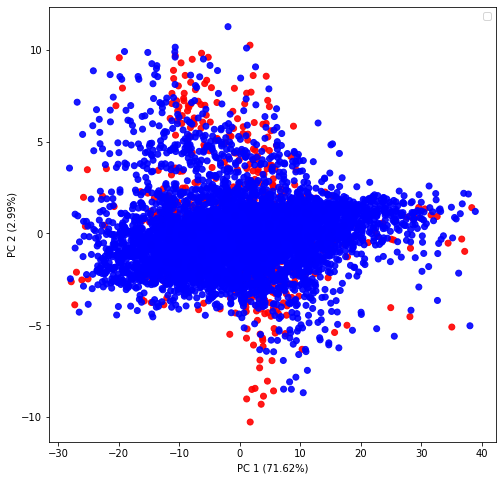

In [31]:
plt.figure(figsize=(8,8))
plt.scatter(pca_result[:,0], pca_result[:,1], c=cvec, alpha=0.9)
plt.legend()
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100))

# T-Distributed Stochastic Neighbouring Entities (t-SNE) Plot

In [32]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_train)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5776 samples in 0.001s...
[t-SNE] Computed neighbors for 5776 samples in 1.292s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5776
[t-SNE] Computed conditional probabilities for sample 2000 / 5776
[t-SNE] Computed conditional probabilities for sample 3000 / 5776
[t-SNE] Computed conditional probabilities for sample 4000 / 5776
[t-SNE] Computed conditional probabilities for sample 5000 / 5776
[t-SNE] Computed conditional probabilities for sample 5776 / 5776
[t-SNE] Mean sigma: 2.513217
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.927940
[t-SNE] KL divergence after 300 iterations: 2.355066
t-SNE done! Time elapsed: 13.376618146896362 seconds


Text(0, 0.5, 'tsne-2d-two')

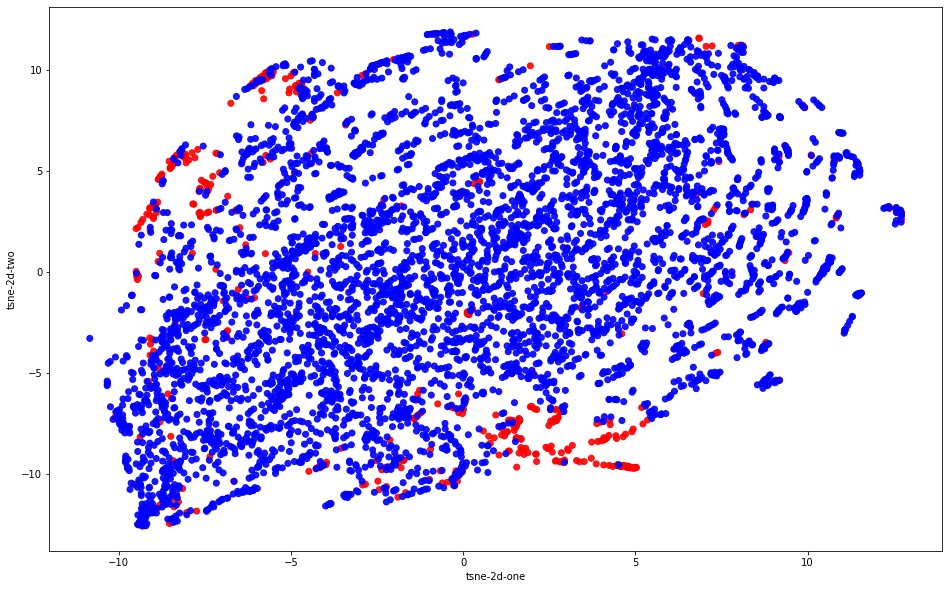

In [33]:
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=cvec, alpha=0.9)
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two') 

# Random forest
First, let's arrange the training data. X_train we have from above. We additionally need to create a data structure for the labels with 1=positive, 0=negative example

In [34]:
print("Training data dimensions:", X_train.shape)

Training data dimensions: (5776, 100)


In [35]:
label_1 = np.ones(diff_vectors_pos.shape[0])
label_0 = np.zeros(diff_vectors_neg.shape[0])
Y_train = np.concatenate((label_1,label_0))
n_pos_examples = sum([x for x in Y_train])
n_neg_examples = sum([(1-x) for x in Y_train])
print("Number of positive examples: %d, number of negative examples: %d, Y_train.shape: %s" % (n_pos_examples, n_neg_examples, Y_train.shape))

Number of positive examples: 559, number of negative examples: 5217, Y_train.shape: (5776,)


## Prediction data
Note that for this pilot experiment, we are not checking ROC, but we are just predicting values for all combinations of protein kinases and cancers

In [36]:
prediction_data = "predictions.tsv"
prediction_df = pd.read_csv(prediction_data, sep='\t')[["mesh_id", "gene_id"]]


In [37]:
prediction_df.head()

,mesh_id,gene_id
0,meshd000008,ncbigene23552
1,meshd000069293,ncbigene23552
2,meshd000069295,ncbigene23552
3,meshd000069584,ncbigene23552
4,meshd000070779,ncbigene23552


In [38]:
prediction_difference_vectors = predictor.get_disease_kinase_difference_vectors(prediction_df)

[INFO] Created 10000/356447 (2.8%) difference vectors
[INFO] Created 20000/356447 (5.6%) difference vectors
[INFO] Created 30000/356447 (8.4%) difference vectors
[INFO] Created 40000/356447 (11.2%) difference vectors
[INFO] Created 50000/356447 (14.0%) difference vectors
[INFO] Created 60000/356447 (16.8%) difference vectors
[INFO] Created 70000/356447 (19.6%) difference vectors
[INFO] Created 80000/356447 (22.4%) difference vectors
[INFO] Created 90000/356447 (25.2%) difference vectors
[INFO] Created 100000/356447 (28.1%) difference vectors
[INFO] Created 110000/356447 (30.9%) difference vectors
[INFO] Created 120000/356447 (33.7%) difference vectors
[INFO] Created 130000/356447 (36.5%) difference vectors
[INFO] Created 140000/356447 (39.3%) difference vectors
[INFO] Created 150000/356447 (42.1%) difference vectors
[INFO] Created 160000/356447 (44.9%) difference vectors
[INFO] Created 170000/356447 (47.7%) difference vectors
[INFO] Created 180000/356447 (50.5%) difference vectors
[INF

In [39]:
prediction_difference_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene23552-meshd000008,0.708197,1.290104,0.561938,-0.099391,1.151502,-0.743111,-1.097506,-1.140788,-0.228039,-0.000998,...,-0.584290,0.115289,0.182056,-1.740004,1.747286,1.337672,-1.003394,-0.067877,0.314209,-0.146105
ncbigene23552-meshd000069293,1.422597,0.577610,0.680395,0.114170,1.359240,-0.015148,-0.157970,-0.657875,0.065483,0.014552,...,-0.376531,0.509528,-0.034168,-1.419383,1.380829,1.882058,-0.301778,-0.201751,0.157687,0.624365
ncbigene23552-meshd000069584,0.679305,-0.004023,0.523511,-0.450354,0.490123,-0.402770,-1.688186,-2.444986,-0.504033,-0.748134,...,0.045433,-0.717899,0.331410,-0.820566,1.714909,0.100310,-0.417283,0.213280,1.174330,0.138305
ncbigene23552-meshd000070779,1.151146,0.914599,0.629768,0.571509,0.826595,-0.892867,-0.926174,-0.515938,0.383801,-0.677248,...,-0.393525,-0.404764,0.297285,-0.904665,1.380163,1.050284,0.172301,-0.037946,0.460384,-0.532447
ncbigene23552-meshd000071380,1.654519,0.218517,1.167848,0.482340,1.093505,0.097858,-1.306451,-0.876615,0.321109,-0.974852,...,-0.926187,0.802710,1.364528,-1.569548,0.882294,1.580470,-1.177857,0.321215,0.507300,0.833965


In [40]:
prediction_difference_vectors.shape

(330922, 100)

# Save binary versions of the data for use in other notebooks
We 'pickle' the three pandas dataframes produced by the code in this notebook.

In [41]:
prediction_pickle_path = "predictions.pkl"
prediction_difference_vectors.to_pickle(prediction_pickle_path)

In [42]:
positive_diff_pickle_path =  "positive-vectors.pkl"
diff_vectors_pos.to_pickle(positive_diff_pickle_path)

In [43]:
negative_diff_pickle_path = "negative-vectors.pkl"
diff_vectors_neg.to_pickle(negative_diff_pickle_path)